# MCT Assignment 2 - Question 1 - Training a neural network to reproduce a double Exclusive Or (XOR) behaviour

## Truth Table For $A \oplus B \oplus C$
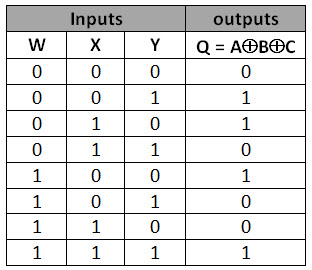

## Proposed Feed Forward Neural Network
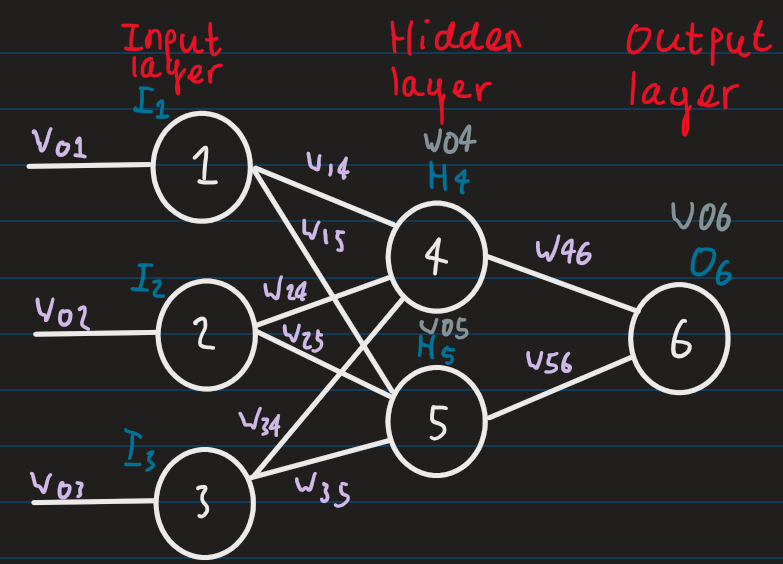

It is known that with continuous activitation functions for the neurons, parity problems can be solved with $n_{hidden}=n_{in}-1$ (also have been told so in the assignment)

## Imports
Numpy for maths

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Defining initial values and constants
### Weighting
$w = \left \{ w_{i, j} \right \}$

Where if $i = 0$ defines an implicit weighting for a node

$w_{0,1}, w_{0, 2}, w_{0, 3}$ are all equal to 1 as each input is equal in importance for the XOR problem

Weights are defined as random values between $\left [ -0.1, 0.1 \right ]$

Weight array is list of weights like so $\left [ w_{0,4}, w_{0,5}, w_{0,6}, w_{1,4}, w_{1,5}, w_{2,4}, w_{2,5}, w_{3,4}, w_{3,5}, w_{4,6}, w_{5,6}\right ]$

### Truth table
Truth table is determined in the TT variable, these are our input output functions.

Characterised by a set of input-output patterns, represented mathematically as $D_t=\left \{ x_p, t_p \right \}$ where $x_p$ and $t_p$ are input patterns and target output patterns respectively.

### Metropolis Parameters
Delta is our stepsize

Inverse temperature is beta

In [2]:
rng = np.random.default_rng() # Random number generator
k = 1.0
delta = 0.05 # stepsize
beta_0 = 5 #initial inverse temperature
beta = beta_0

n_out = 1
n_patts = 8

TT = [
    [0, 0, 0, 0],
    [0, 0, 1, 1],
    [0, 1, 0, 1],
    [0, 1, 1, 0],
    [1, 0, 0, 1],
    [1, 0, 1, 0],
    [1, 1, 0, 0],
    [1, 1, 1, 1]
]

## Defining our functions
### Energy (error) function
We first define an energy function - the output of which we hope to minimise - this can be defined multiple ways, two are defined below.
1. 
> $E(w)=(t_p-out_p)^2$ 
(as defined in neural network lecture notes) (Eq 1)
2. 
> $E(w)=\frac{\sum_p\left | out_p - t_p \right |^2}{n_{out}n_{patts}}$ 
(where $n_{out}$ and $n_{patts}$ are number of output nodes and patterns(number of rows in truth table)) (Eq 2)

It is important to note that the Metropolis algorithm is not dependent on the energy (error) function, thus any form of error function could be implemented.

For this implementation we go for the second function for error calculations.

### Introducing Boltzmann-Gibbs probability Distribution
A neural network with weights and patterns can be treated as a statistical system.

We introduce dynamics by demanding our system obeys Boltzmann-Gibbs probability dimension
> $P(\left \{ w_{i, j} \right \})=\frac{e^{-\beta E(w)}}{Z}$ (Eq 3)

Where the partition function, $Z$, is given by:
> $Z=\sum_{w_{i,j}}e^{-\beta E(w)}$ (Eq 4)

For a system obeying eq(3), as $\beta \rightarrow \infty$ energy approaches a minimum

### Calculating node input and output
To work out input for each hidden node:
> $X_i=w_{0i}+w_{1i}I_1+w_{2i}I_2+w_{3i}I_3$ for $I=4,5$

Output of each node in the hidden layer is given by:
> $H_h=\frac{1}{1+e^{-k\cdot X_h}}$ for $h=5, 6, 7$

Inputs to the output nodes given by:
> $X = w_{06} + w_{46}H_4 + w_{56}H_5$

Output node given by:
> $O=\frac{1}{1+e^{-k\cdot X}}$

In [3]:
def calcNodeOutput(x):
    return 1.0 / (1.0 + np.exp(-k * x))

def calcError(targets, outputs):
    sum = 0
    
    for i in range(len(targets)):
        sum += (outputs[i] - targets[i])**2
           
    return sum/(n_out * n_patts)

def network_test():
    correct = 0; err = 0.0
    
    targets=np.zeros(len(TT))
    outputs=np.zeros(len(TT))
    
    for i in range(len(TT)):
        i1=TT[i][0]; i2=TT[i][1]; i3=TT[i][2]
        h4=calcNodeOutput(w[0] + w[3]*i1 + w[5]*i2 + w[7]*i3)
        h5=calcNodeOutput(w[1] + w[4]*i1 + w[6]*i2 + w[8]*i3)
        o6=calcNodeOutput(w[2] + w[9]*h4 + w[10]*h5)
        targets[i] = TT[i][3]
        outputs[i] = o6
        if(int(round(o6)) == TT[i][3]):
            correct+=1
            
    err = calcError(targets, outputs)
    return correct, err

def beta_warming(error):    
    #return beta + np.exp(beta_0 / error)
    return np.exp(beta_0 / error)

def beta_cooling(error):
    print("beta cooling")
    
    cooled_value = np.log(beta_0 / error)
    return cooled_value

## Method (Metropolis algorithm)
Metropolis algorithm generates the next configuration by using the former one in the chain. Therefore, there is always a small correlation between subsequent configurations.

We can avoid this by using an N-hit Metropolis algorithm by measuring observables on every Nth interation.

The configuration is generated in the Basic Metropolis Update Step (BMUS).

The overall problem is solved in the Total Update Algorithm (TUA).

### Total-Update Algorithm (TUA):
1. Set stepsize $\delta$ (learning rate) and inverse temperature $\beta$
2. Initialise network by generating weights uniformly in a range, in this case $\left [ -0.1, 0.1 \right ]$
3. Perform 10 BMUS as explained below and measure observables on the Nth iteration (measuring energy of the network)
4. Check for the last 30 TUA iterations that the energy of the system is getting smaller
> if it is then heat the system by increasing beta such that it tends to infinity as the error of the system reaches a minimum - meaning less statistical fluctuations occur
> if it isn't then cool the system by decreasing beta - allowing more random statistical fluctuations to occur
5. If cooling has occurred check that it has worked, if it hasn't reset the weights of the system - this is because the energy has reached a minimum that doesn't provide the correct answer
6. Repeat steps 3-5 for selected number of TUA iterations

### Basic Metropolis Update Step (BMUS)
1. Loop over all weights $w_{i, j}$ in network and for each do the following
2. Draw random number uniformly between $-1.0$ and $1.0$ such that 
> $r \in U (-1, 1)$
3. Propose change in given weight by
> $w_{i, j} = w_{i, j} + r \cdot\delta$
4. Compute new energy $E'$ of network, and compare with current energy $E_0$
5. If $\Delta E = E' - E_0 < 0$ accept change ($E_0=E'$), else draw number $p\in U(0, 1)$ and accept change if $p < e^{-\beta \Delta E}$ ($E_0=E'$) else reject proposed change and keep old value ($E_0 = E_0$)

### Observations of algorithm
This means the algorithm will always accept weight-changes that decrease energy, but also accepts some weight changes that increase the energy.

The reasoning for this is that this will introduce statistical fluctuations into the system.

In [12]:
def BMUS(error_0):
    for i in range(len(w)):
        old_weight = w[i]
        r = 2.0 * rng.random(size=1)[0] - 1.0
        
        w[i] = w[i] + r * delta
        new_correct, new_error = network_test()
        
        delta_E = new_error - error_0
        
        if(delta_E > 0): # if error has gotten larger
            p = rng.random(size=1)[0]
            if(p > np.exp(-beta * delta_E)): # if statistical fluctuation is not allowed
                w[i] = old_weight

# initialise beta and weights
beta = beta_0
w = (2.0 * rng.random(size=11) - 1.0)
print("inital weights are: ", w)

# initialise variables needed for looping/outputs
n_correct = 0
N_BMU_iterations = 10
tua_n = 500
bmus_n = 0
n_cooling = 0
n_actual_cooling = 0
n_reset = 0
correct_found = -1
errors = np.zeros(tua_n)
iteration = np.linspace(1, tua_n, tua_n)
n_since_last_cool = -1

while(n_correct != 8): # TODO implement this correctly

    for i in range(tua_n):

        n_correct, error_0 = network_test()
        errors[i] = error_0

        # record when correct value was found
        if(n_correct == 8 and correct_found == -1):
             correct_found = i+1

        # for first 200 iterations don't allow beta cooling, only warm beta
        if(i < 200):
            # warm beta value
            beta = beta_warming(errors[i])
        else:
            # calculate the mean and variation for the last 30 error values
            prev_30_errors = errors[i-29:i]
            mean = np.mean(prev_30_errors)
            var = np.var(prev_30_errors)

            # if there has recently been cooling, add one to the counter for how many iterations
            # it has been since last cool
            if(n_since_last_cool > -1):
                        n_since_last_cool += 1

            # if error value hasn't changed enough to go above the threshold var/mean value, we haven't already got the correct answer
            # we haven't already cooled for these weight values and there hasn't recently been a cooling from last set of weights
            # then start cooling
            if(var/mean < 0.000000001 and n_correct != 8 and n_cooling < 1 and (n_since_last_cool > 250 or n_since_last_cool == -1)): #0.000001%
                n_cooling += 1
                n_actual_cooling += 1

                beta = beta_cooling(errors[i])
                n_since_last_cool = 0

            # if there's been cooling and it hasn't worked then reset weights and beta value
            elif(var/mean < 0.00000001 and n_since_last_cool > 200 and n_correct != 8 and n_cooling == 1):
                print("Resetting weights")
                w = (2.0 * rng.random(size=11) - 1.0)
                beta=beta_0
                n_cooling = 0
                n_reset += 1

            # if cooling has ended/not happened then just warm value as per norm
            elif(n_since_last_cool > 100 or n_since_last_cool == -1):
                #delta_E = np.absolute(errors[i] - errors[i-1])
                beta = beta_warming(errors[i])
            # if cooling has recently started continue cooling beta value
            elif(n_since_last_cool < 50):
                #delta_E = np.absolute(errors[i] - errors[i-1])
                beta = beta_cooling(errors[i])

        # for number of BMU iterations complete a BMUS without checking error value
        for j in range(N_BMU_iterations):
            BMUS(error_0)
            bmus_n += 1

        print("Iteration", i+1)
        print(network_test()) 
        print("Inverse Temperature - ", beta)


print("Initial Neural Network completed")
#print("There were", tua_n, "completed TUA iterations")
#print("There were", bmus_n, "completed BMUS iterations")
print("Beta was cooled", n_actual_cooling, "times")
if(correct_found == -1):
    print("The correct truth table was not reproduced")
else:
    print("The correct truth table was found in", correct_found, "iterations")
print("Final error was", errors[-1])
print("The weights and beta was reset", n_reset, "times")

inital weights are:  [ 0.11835009 -0.0154973  -0.40446449  0.94148942 -0.3857983   0.74786417
 -0.33209974  0.96644854 -0.47012361  0.6205121   0.92495616]
Iteration 1
(4, 0.253918383758718)
Inverse Temperature -  222681808.10794836
Iteration 2
(4, 0.25122316763416197)
Inverse Temperature -  356329589.7936916
Iteration 3
(4, 0.24987522766746006)
Inverse Temperature -  440148629.75508744
Iteration 4
(4, 0.24980074230772437)
Inverse Temperature -  490034703.9231553
Iteration 5
(5, 0.24971343575300115)
Inverse Temperature -  492967265.231387
Iteration 6
(5, 0.2496182380141304)
Inverse Temperature -  496429207.40845174
Iteration 7
(6, 0.2495725240089407)
Inverse Temperature -  500234560.6605846
Iteration 8
(4, 0.2495124010652469)
Inverse Temperature -  502073285.9127011
Iteration 9
(4, 0.2494512424881654)
Inverse Temperature -  504502899.15333384
Iteration 10
(4, 0.24943990119166262)
Inverse Temperature -  506987636.7097389
Iteration 11
(4, 0.24930114813237114)
Inverse Temperature -  50744

Iteration 106
(4, 0.19781481998170647)
Inverse Temperature -  93186302122.85013
Iteration 107
(7, 0.19649668842865245)
Inverse Temperature -  94907147122.13245
Iteration 108
(4, 0.19568312984324837)
Inverse Temperature -  112444033186.74219
Iteration 109
(7, 0.19558593772339183)
Inverse Temperature -  124991655456.08553
Iteration 110
(7, 0.19507217866288923)
Inverse Temperature -  126588825510.77817
Iteration 111
(7, 0.19498661937350614)
Inverse Temperature -  135405281638.18816
Iteration 112
(7, 0.1938133099192309)
Inverse Temperature -  136936782268.40468
Iteration 113
(7, 0.19330672418438063)
Inverse Temperature -  159933162216.4792
Iteration 114
(7, 0.19325626253690453)
Inverse Temperature -  171119664877.14935
Iteration 115
(7, 0.1916277371941881)
Inverse Temperature -  172279291604.97653
Iteration 116
(7, 0.1885104982364293)
Inverse Temperature -  214646028123.54218
Iteration 117
(7, 0.18841416539704225)
Inverse Temperature -  330450178307.27985
Iteration 118
(7, 0.18748603758494

Iteration 219
(7, 0.11444165085990801)
Inverse Temperature -  9.022426709919134e+18
Iteration 220
(7, 0.11429428364169728)
Inverse Temperature -  9.42961430667869e+18
Iteration 221
(7, 0.11401318447835604)
Inverse Temperature -  9.976058929388847e+18
Iteration 222
(7, 0.11348625853377353)
Inverse Temperature -  1.1112221309462436e+19
Iteration 223
(7, 0.1131564942482478)
Inverse Temperature -  1.3621724342969076e+19
Iteration 224
(7, 0.11290618729834176)
Inverse Temperature -  1.548794081479495e+19
Iteration 225
(7, 0.1128939889392847)
Inverse Temperature -  1.7081927140000586e+19
Iteration 226
(7, 0.11265100258038221)
Inverse Temperature -  1.7163860202379352e+19
Iteration 227
(7, 0.11216390174896802)
Inverse Temperature -  1.8884422859590824e+19
Iteration 228
(7, 0.111941720292513)
Inverse Temperature -  2.28989303396871e+19
Iteration 229
(7, 0.11111851178963221)
Inverse Temperature -  2.5017302266632372e+19
Iteration 230
(7, 0.11030644400096254)
Inverse Temperature -  3.482972716206

Iteration 320
(7, 0.09588668980620631)
Inverse Temperature -  4.391579349661298e+22
Iteration 321
(7, 0.0958796138259676)
Inverse Temperature -  4.4282684882961985e+22
Iteration 322
(7, 0.09583388200904311)
Inverse Temperature -  4.445342747868813e+22
Iteration 323
(7, 0.09576173463657744)
Inverse Temperature -  4.557354435005282e+22
Iteration 324
(7, 0.09574850587364166)
Inverse Temperature -  4.740061692057103e+22
Iteration 325
(7, 0.09568485332331482)
Inverse Temperature -  4.774379269686e+22
Iteration 326
(7, 0.09567894361285198)
Inverse Temperature -  4.94314828883681e+22
Iteration 327
(7, 0.09564102512106606)
Inverse Temperature -  4.959128456368514e+22
Iteration 328
(7, 0.0956209296992711)
Inverse Temperature -  5.06294643726747e+22
Iteration 329
(7, 0.09561240349878283)
Inverse Temperature -  5.118878548125598e+22
Iteration 330
(7, 0.09556298853426848)
Inverse Temperature -  5.142803226461232e+22
Iteration 331
(7, 0.0955229851074553)
Inverse Temperature -  5.283767668221485e+22

Iteration 436
(7, 0.09393350953318842)
Inverse Temperature -  1.3044000621150845e+23
Iteration 437
(7, 0.09393310142582284)
Inverse Temperature -  1.3095500569632657e+23
Iteration 438
(7, 0.09392682227073819)
Inverse Temperature -  1.3098529418123742e+23
Iteration 439
(7, 0.0939260285339229)
Inverse Temperature -  1.3145223130379652e+23
Iteration 440
(7, 0.09392073492558997)
Inverse Temperature -  1.3151137883063878e+23
Iteration 441
(7, 0.09391785663359263)
Inverse Temperature -  1.3190655375908048e+23
Iteration 442
(7, 0.09391704833993753)
Inverse Temperature -  1.3212193898201243e+23
Iteration 443
(7, 0.09391312721444314)
Inverse Temperature -  1.3218248993793609e+23
Iteration 444
(7, 0.09390801011126479)
Inverse Temperature -  1.3247663848833035e+23
Iteration 445
(7, 0.09390766776306801)
Inverse Temperature -  1.3286152674393065e+23
Iteration 446
(7, 0.09390302162456865)
Inverse Temperature -  1.328873181930862e+23
Iteration 447
(7, 0.09390263463624322)
Inverse Temperature -  1.332

Iteration 39
(7, 0.09379250024321759)
Inverse Temperature -  1.4182781147745217e+23
Iteration 40
(7, 0.09379155810305705)
Inverse Temperature -  1.4186549920937256e+23
Iteration 41
(7, 0.09379120385892578)
Inverse Temperature -  1.419414875103275e+23
Iteration 42
(7, 0.09379072522847555)
Inverse Temperature -  1.419700699886357e+23
Iteration 43
(7, 0.09378927180025566)
Inverse Temperature -  1.4200869816427243e+23
Iteration 44
(7, 0.0937883966820404)
Inverse Temperature -  1.4212606486215567e+23
Iteration 45
(7, 0.0937881110150789)
Inverse Temperature -  1.4219678062076129e+23
Iteration 46
(7, 0.09378788740775049)
Inverse Temperature -  1.4221987243973059e+23
Iteration 47
(7, 0.09378724523785598)
Inverse Temperature -  1.4223795039803814e+23
Iteration 48
(7, 0.09378684293172912)
Inverse Temperature -  1.4228988109678758e+23
Iteration 49
(7, 0.0937867526887675)
Inverse Temperature -  1.4232242462464358e+23
Iteration 50
(7, 0.09378653927751807)
Inverse Temperature -  1.423297256591552e+2

Iteration 150
(7, 0.09376932312495148)
Inverse Temperature -  1.4374394729106039e+23
Iteration 151
(7, 0.09376930177413928)
Inverse Temperature -  1.4374716168065117e+23
Iteration 152
(7, 0.09376921843768644)
Inverse Temperature -  1.4374890695962464e+23
Iteration 153
(7, 0.09376910198648966)
Inverse Temperature -  1.4375571933983444e+23
Iteration 154
(7, 0.09376907634333248)
Inverse Temperature -  1.4376523926247714e+23
Iteration 155
(7, 0.09376904805507003)
Inverse Temperature -  1.4376733568666434e+23
Iteration 156
(7, 0.09376900839361019)
Inverse Temperature -  1.4376964839491357e+23
Iteration 157
(7, 0.09376900402599127)
Inverse Temperature -  1.4377289098445363e+23
Iteration 158
(7, 0.09376892748629163)
Inverse Temperature -  1.4377324807114315e+23
Iteration 159
(7, 0.09376891621511366)
Inverse Temperature -  1.4377950593400719e+23
Iteration 160
(7, 0.0937688437641527)
Inverse Temperature -  1.4378042748600664e+23
Iteration 161
(7, 0.09376881319815963)
Inverse Temperature -  1.43

Iteration 254
(5, 0.13409815070420192)
Inverse Temperature -  3.6385238577187553
Iteration 255
(5, 0.12675788052781933)
Inverse Temperature -  3.6385238577187553
Iteration 256
(5, 0.14136022515488408)
Inverse Temperature -  3.6385238577187553
Iteration 257
(5, 0.1390395316207247)
Inverse Temperature -  3.6385238577187553
Iteration 258
(5, 0.1570097804909037)
Inverse Temperature -  3.6385238577187553
Iteration 259
(5, 0.158178327897205)
Inverse Temperature -  3.6385238577187553
Iteration 260
(5, 0.14838601183977443)
Inverse Temperature -  3.6385238577187553
Iteration 261
(5, 0.15098556980253075)
Inverse Temperature -  3.6385238577187553
Iteration 262
(5, 0.15631896021308028)
Inverse Temperature -  3.6385238577187553
Iteration 263
(5, 0.16121758981108134)
Inverse Temperature -  3.6385238577187553
Iteration 264
(5, 0.14246610024972947)
Inverse Temperature -  3.6385238577187553
Iteration 265
(5, 0.15443373034844388)
Inverse Temperature -  3.6385238577187553
Iteration 266
(5, 0.158379306104

Iteration 367
(7, 0.09376266709719959)
Inverse Temperature -  1.4428915523604524e+23
Iteration 368
(7, 0.09376266262536587)
Inverse Temperature -  1.4429231152024652e+23
Iteration 369
(7, 0.09376262916888035)
Inverse Temperature -  1.4429267849780695e+23
Iteration 370
(7, 0.09376259720186916)
Inverse Temperature -  1.4429542410902655e+23
Iteration 371
(7, 0.09376254107833257)
Inverse Temperature -  1.442980475369626e+23
Iteration 372
(7, 0.09376248462175849)
Inverse Temperature -  1.4430265353154733e+23
Iteration 373
(7, 0.09376247004742096)
Inverse Temperature -  1.4430728701203592e+23
Iteration 374
(7, 0.09376245709473476)
Inverse Temperature -  1.4430848317607705e+23
Iteration 375
(7, 0.09376244108941525)
Inverse Temperature -  1.443095462544683e+23
Iteration 376
(7, 0.09376243442007931)
Inverse Temperature -  1.4431085988581959e+23
Iteration 377
(7, 0.09376243307492346)
Inverse Temperature -  1.443114072730427e+23
Iteration 378
(7, 0.09376242599031845)
Inverse Temperature -  1.4431

Iteration 481
(5, 0.22690459627942758)
Inverse Temperature -  3642865161.6209025
Iteration 482
(5, 0.2267065877615355)
Inverse Temperature -  3715179734.348603
Iteration 483
(5, 0.22637393011640444)
Inverse Temperature -  3787375586.8616643
Iteration 484
(4, 0.2250698413959875)
Inverse Temperature -  3912134635.2645044
Iteration 485
(5, 0.22453769125456752)
Inverse Temperature -  4446248069.588023
Iteration 486
(5, 0.22441274977352235)
Inverse Temperature -  4686614747.311255
Iteration 487
(4, 0.22436690485851968)
Inverse Temperature -  4745079488.122935
Iteration 488
(3, 0.222980958914388)
Inverse Temperature -  4766730953.410252
Iteration 489
(5, 0.222461284974638)
Inverse Temperature -  5474897068.682762
Iteration 490
(4, 0.22218395076243466)
Inverse Temperature -  5769324893.488516
Iteration 491
(4, 0.22167416762316663)
Inverse Temperature -  5933473641.701312
Iteration 492
(4, 0.22113133886054825)
Inverse Temperature -  6248627769.939069
Iteration 493
(6, 0.22013513578839772)
Inve

Iteration 90
(7, 0.11363099878807927)
Inverse Temperature -  1.1033200628480879e+19
Iteration 91
(7, 0.11324011292653535)
Inverse Temperature -  1.28783253580331e+19
Iteration 92
(7, 0.11302544380216092)
Inverse Temperature -  1.4990752011489407e+19
Iteration 93
(7, 0.11297667840850928)
Inverse Temperature -  1.630211843887084e+19
Iteration 94
(7, 0.11273777333429744)
Inverse Temperature -  1.6616396276280003e+19
Iteration 95
(7, 0.11262484726557863)
Inverse Temperature -  1.8250194603277173e+19
Iteration 96
(7, 0.11224188089935581)
Inverse Temperature -  1.908008400960437e+19
Iteration 97
(7, 0.11179551500798048)
Inverse Temperature -  2.2200620803606467e+19
Iteration 98
(7, 0.11139586258616277)
Inverse Temperature -  2.6522187459235856e+19
Iteration 99
(7, 0.10998100983418002)
Inverse Temperature -  3.113830621135369e+19
Iteration 100
(7, 0.10938468377070715)
Inverse Temperature -  5.547110816287368e+19
Iteration 101
(7, 0.10813822216673208)
Inverse Temperature -  7.107296161758488e+

Iteration 201
(7, 0.09472930704996542)
Inverse Temperature -  8.32535783166621e+22
Iteration 202
(7, 0.09470218826103584)
Inverse Temperature -  8.373766939908867e+22
Iteration 203
(7, 0.09469667619404215)
Inverse Temperature -  8.501294194996292e+22
Iteration 204
(7, 0.09466782540840685)
Inverse Temperature -  8.527460493615313e+22
Iteration 205
(7, 0.09463637354625251)
Inverse Temperature -  8.665788172396783e+22
Iteration 206
(7, 0.09461802872814504)
Inverse Temperature -  8.819243208790899e+22
Iteration 207
(7, 0.09459856846712476)
Inverse Temperature -  8.91004805146761e+22
Iteration 208
(7, 0.0945723287640794)
Inverse Temperature -  9.007435490871612e+22
Iteration 209
(7, 0.0944808600477107)
Inverse Temperature -  9.140502310069202e+22
Iteration 210
(7, 0.09447386175713803)
Inverse Temperature -  9.620530355935923e+22
Iteration 211
(7, 0.09443411911989806)
Inverse Temperature -  9.658318626690519e+22
Iteration 212
(7, 0.09439167219472212)
Inverse Temperature -  9.87585565608027e+

Iteration 311
(7, 0.08912438960546343)
Inverse Temperature -  1.9522520808404179e+24
Iteration 312
(7, 0.08888683064495961)
Inverse Temperature -  2.3148010848156575e+24
Iteration 313
(7, 0.0888569982414433)
Inverse Temperature -  2.6892444506292084e+24
Iteration 314
(7, 0.08825275753864317)
Inverse Temperature -  2.7405148695423203e+24
Iteration 315
(7, 0.08804032072364744)
Inverse Temperature -  4.028569124952167e+24
Iteration 316
(7, 0.08787282091535788)
Inverse Temperature -  4.618721725794461e+24
Iteration 317
(7, 0.08691672624838061)
Inverse Temperature -  5.146789006912154e+24
Iteration 318
(7, 0.08644249341324964)
Inverse Temperature -  9.624236812478314e+24
Iteration 319
(7, 0.08537943656041373)
Inverse Temperature -  1.3195557416494408e+25
Iteration 320
(7, 0.0840044562203924)
Inverse Temperature -  2.711449045999512e+25
Iteration 321
(7, 0.0833664985416463)
Inverse Temperature -  7.071160522723493e+25
Iteration 322
(7, 0.08236719946737983)
Inverse Temperature -  1.1150710577

Iteration 426
(8, 0.019096956418745675)
Inverse Temperature -  4.862185130678607e+113
Iteration 427
(8, 0.018987036156487884)
Inverse Temperature -  5.1023971582888396e+113
Iteration 428
(8, 0.018377853436827418)
Inverse Temperature -  2.323027634884867e+114
Iteration 429
(8, 0.018300828924278357)
Inverse Temperature -  1.4355579560802495e+118
Iteration 430
(8, 0.018145859132956167)
Inverse Temperature -  4.511488914018209e+118
Iteration 431
(8, 0.01813229148022784)
Inverse Temperature -  4.652163303482533e+119
Iteration 432
(8, 0.018015870709407994)
Inverse Temperature -  5.7173840681663574e+119
Iteration 433
(8, 0.017937944069379312)
Inverse Temperature -  3.396902609478761e+120
Iteration 434
(8, 0.017873291285190995)
Inverse Temperature -  1.1342229110537683e+121
Iteration 435
(8, 0.01769569737711413)
Inverse Temperature -  3.108763838160915e+121
Iteration 436
(8, 0.017511206670853652)
Inverse Temperature -  5.150941069122205e+122
Iteration 437
(8, 0.017391148896990612)
Inverse Temp

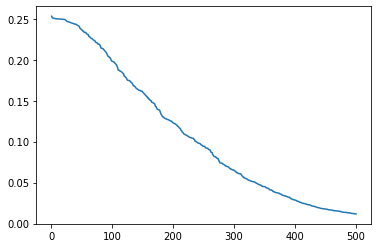

In [9]:
plt.plot(iteration, errors)
plt.show()

In [6]:
# final outputs
print ("  X1   X2   X3   |  target   actual ")
for i in range(len(TT)):
    i1=TT[i][0]; i2=TT[i][1]; i3=TT[i][2]
    h4=calcNodeOutput(w[0] + w[3]*i1 + w[5]*i2 + w[7]*i3)
    h5=calcNodeOutput(w[1] + w[4]*i1 + w[6]*i2 + w[8]*i3)
    o6=calcNodeOutput(w[2] + w[9]*h4 + w[10]*h5)
    
    print(" ",TT[i][0], "  ", TT[i][1],"  ", TT[i][2], "   |   " , TT[i][3], "    " , o6)

  X1   X2   X3   |  target   actual 
  0    0    0    |    0      1.060621120730018e-05
  0    0    1    |    1      0.9999886071033602
  0    1    0    |    1      0.9999856538957127
  0    1    1    |    0      8.544116422381557e-06
  1    0    0    |    1      0.9999906421851394
  1    0    1    |    0      1.4243950287760671e-05
  1    1    0    |    0      1.0391591632991714e-05
  1    1    1    |    1      0.9999883669828393
